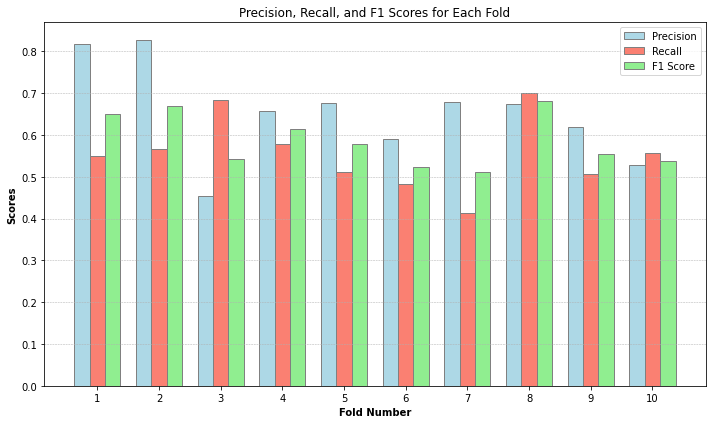

Best K: 19
Precision: 0.8519, Recall: 0.7188, F1 Score: 0.7797


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

# Load the data
data = pd.read_csv('cleveland.csv')
data['num'] = data['num'].apply(lambda x: 1 if x > 0 else 0)
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 40, 50, 60, 70, 100], labels=[1, 2, 3, 4, 5, 6])
features = ['age_group', 'thalach', 'exang', 'oldpeak']

# KNN function
def knn(X_train, y_train, X_test, k):
    distances = np.sqrt(np.sum((X_train - X_test) ** 2, axis=1))
    nearest_neighbors = np.argsort(distances)[:k]
    nearest_labels = y_train.iloc[nearest_neighbors]
    prediction = Counter(nearest_labels).most_common(1)[0][0]
    return prediction

# Cross-validation function
def cross_validate(X_train, y_train, k, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        predictions = [knn(X_fold_train.values, y_fold_train, x, k) for x in X_fold_val.values]
        
        precision = precision_score(y_fold_val, predictions)
        recall = recall_score(y_fold_val, predictions)
        f1 = f1_score(y_fold_val, predictions)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    return precision_scores, recall_scores, f1_scores

# To evaluate all features
def evaluate_all_features(k_values=range(1, 21), num_folds=10):
    X = data[features]
    y = data['num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_k = None
    best_f1_mean = 0
    best_precision = None
    best_recall = None
    all_f1_scores = []
    all_precision_scores = []
    all_recall_scores = []

    for k in k_values:
        precision_scores, recall_scores, f1_scores = cross_validate(X_train, y_train, k, num_folds)
        mean_f1 = np.mean(f1_scores)
        all_f1_scores.append(f1_scores)
        all_precision_scores.append(precision_scores)
        all_recall_scores.append(recall_scores)

        if mean_f1 > best_f1_mean:
            best_f1_mean = mean_f1
            best_k = k
            best_precision = np.mean(precision_scores)
            best_recall = np.mean(recall_scores)
    
    # Final evaluation on the test set using the best k
    final_predictions = [knn(X_train.values, y_train, x, best_k) for x in X_test.values]
    final_precision = precision_score(y_test, final_predictions)
    final_recall = recall_score(y_test, final_predictions)
    final_f1 = f1_score(y_test, final_predictions)
    
    return {
        'k': best_k,
        'precision': final_precision,
        'recall': final_recall,
        'f1': final_f1,
        'all_f1_scores': all_f1_scores,
        'all_precision_scores': all_precision_scores,
        'all_recall_scores': all_recall_scores
    }
results = evaluate_all_features()

#data for plotting using mean scores for each fold
mean_precision_per_fold = np.mean(results['all_precision_scores'], axis=0)
mean_recall_per_fold = np.mean(results['all_recall_scores'], axis=0)
mean_f1_per_fold = np.mean(results['all_f1_scores'], axis=0)
folds = list(range(1, len(mean_precision_per_fold) + 1))

#using histogram to visualize each folds best values
bar_width = 0.25
r1 = np.arange(len(folds))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 6))
plt.bar(r1, mean_precision_per_fold, color='lightblue', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, mean_recall_per_fold, color='salmon', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, mean_f1_per_fold, color='lightgreen', width=bar_width, edgecolor='grey', label='F1 Score')
plt.xlabel('Fold Number', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(folds))], folds)
plt.title('Precision, Recall, and F1 Scores for Each Fold')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best K: {results['k']}")
print(f"Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}, F1 Score: {results['f1']:.4f}")


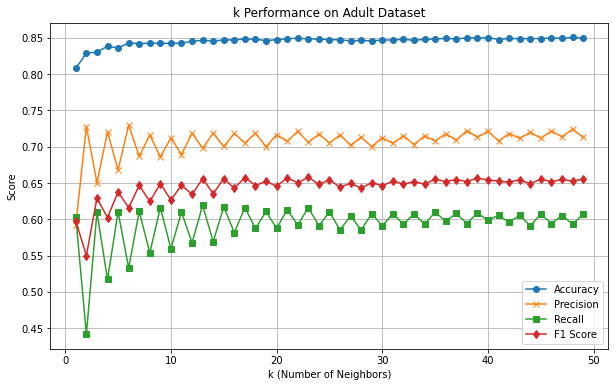

Best k based on F1 score: 23
Best k: 23
Precision: 0.7057
Recall: 0.6160
F1 Score: 0.6578


In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt


columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', header=None, names=columns)

# missing values are represented as ?
df = df.replace('?', np.nan)
df = df.dropna()

#turn categorical variables into numerical values
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

# standardize
scaler = StandardScaler()
df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])

# Encode the target variable (income)
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])  # '>50K' becomes 1, '<=50K' becomes 0

#features (X) and target (y)
X = df.drop('income', axis=1).values
y = df['income'].values

#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#store results
k_values = list(range(1, 50))  # k from 1 to 50
accuracies = []
precision_list = []
recall_list = []
f1_list = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    accuracies.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

#plot accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.plot(k_values, precision_list, marker='x', label='Precision')
plt.plot(k_values, recall_list, marker='s', label='Recall')
plt.plot(k_values, f1_list, marker='d', label='F1 Score')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Score')
plt.title('k Performance on Adult Dataset')
plt.legend()
plt.grid()
plt.show()

#best k based on F1
best_k = k_values[np.argmax(f1_list)]
print(f"Best k based on F1 score: {best_k}")

#best k-NN model
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

#report for the best k
precision_best, recall_best, f1_best, _ = precision_recall_fscore_support(y_test, y_pred_best, average='binary')
print(f"Best k: {best_k}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")


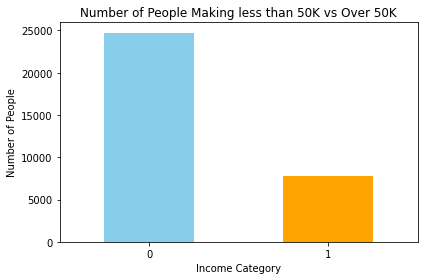

In [4]:
 # '>50K' becomes 1, '<=50K' becomes 0
income_counts = df['income'].value_counts()
plt.figure(figsize=(6, 4))
income_counts.plot(kind='bar', color=['skyblue', 'orange'])

plt.title('Number of People Making less than 50K vs Over 50K' )
plt.xlabel('Income Category')
plt.ylabel('Number of People')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
# Monte Carlo cross-validation
num_iterations = 10
test_size = 0.25  # 25% test size
k_values = list(range(1, 10))
results = {k: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for k in k_values}

for _ in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=None)
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        
        results[k]['accuracy'].append(acc)
        results[k]['precision'].append(precision)
        results[k]['recall'].append(recall)
        results[k]['f1'].append(f1)

#averages
avg_results = {k: {metric: np.mean(results[k][metric]) for metric in results[k]} for k in k_values}

# Print average results
for k in k_values:
    print(f"k: {k}, Average Accuracy: {avg_results[k]['accuracy']:.4f}, Average Precision: {avg_results[k]['precision']:.4f}, "
          f"Average Recall: {avg_results[k]['recall']:.4f}, Average F1 Score: {avg_results[k]['f1']:.4f}")

k: 1, Average Accuracy: 0.8017, Average Precision: 0.5859, Average Recall: 0.5868, Average F1 Score: 0.5863
k: 2, Average Accuracy: 0.8189, Average Precision: 0.7095, Average Recall: 0.4127, Average F1 Score: 0.5218
k: 3, Average Accuracy: 0.8247, Average Precision: 0.6447, Average Recall: 0.5969, Average F1 Score: 0.6198
k: 4, Average Accuracy: 0.8302, Average Precision: 0.7126, Average Recall: 0.4873, Average F1 Score: 0.5788
k: 5, Average Accuracy: 0.8312, Average Precision: 0.6641, Average Recall: 0.5976, Average F1 Score: 0.6290
k: 6, Average Accuracy: 0.8339, Average Precision: 0.7099, Average Recall: 0.5180, Average F1 Score: 0.5989
k: 7, Average Accuracy: 0.8358, Average Precision: 0.6774, Average Recall: 0.6003, Average F1 Score: 0.6364
k: 8, Average Accuracy: 0.8376, Average Precision: 0.7134, Average Recall: 0.5386, Average F1 Score: 0.6137
k: 9, Average Accuracy: 0.8390, Average Precision: 0.6870, Average Recall: 0.6025, Average F1 Score: 0.6419
